In [16]:
import torch, cv2, os, sys, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from ModelZoo.utils import load_as_tensor, Tensor2PIL, PIL2Tensor, _add_batch_one
from ModelZoo import get_model, load_model, print_network
from SaliencyModel.utils import vis_saliency, vis_saliency_kde, click_select_position, grad_abs_norm, grad_norm, prepare_images, make_pil_grid, blend_input
from SaliencyModel.utils import cv2_to_pil, pil_to_cv2, gini
from SaliencyModel.attributes import attr_grad
from SaliencyModel.BackProp import I_gradient, attribution_objective, Path_gradient
from SaliencyModel.BackProp import saliency_map_PG as saliency_map
from SaliencyModel.BackProp import GaussianBlurPath
from SaliencyModel.utils import grad_norm, IG_baseline, interpolation, isotropic_gaussian_kernel

In [17]:
import math
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint

from basicsr.archs.arch_util import to_2tuple, trunc_normal_

from einops import rearrange

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0], ) + (1, ) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class ChannelAttention(nn.Module):
    """Channel attention used in RCAN.
    Args:
        num_feat (int): Channel number of intermediate features.
        squeeze_factor (int): Channel squeeze factor. Default: 16.
    """

    def __init__(self, num_feat, squeeze_factor=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_feat, num_feat // squeeze_factor, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feat // squeeze_factor, num_feat, 1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        y = self.attention(x)
        return x * y


class CAB(nn.Module):

    def __init__(self, num_feat, compress_ratio=3, squeeze_factor=30):
        super(CAB, self).__init__()

        self.cab = nn.Sequential(
            nn.Conv2d(num_feat, num_feat // compress_ratio, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(num_feat // compress_ratio, num_feat, 3, 1, 1),
            ChannelAttention(num_feat, squeeze_factor)
            )

    def forward(self, x):
        return self.cab(x)


class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops



class SwinBasedFeatFusionBlock(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, shift_size, mlp_ratio, qkv_bias, qk_scale, drop, attn_drop, drop_path, norm_layer, gc, patch_size, img_size):
        super(SwinBasedFeatFusionBlock, self).__init__()

        self.swin1 = SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                          num_heads=num_heads, window_size=window_size,
                                          shift_size=0,  # For first block
                                          mlp_ratio=mlp_ratio,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
                                          drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path[0] if isinstance(drop_path, list) else drop_path,
                                          norm_layer=norm_layer)
        self.adjust1 = nn.Conv2d(dim, gc, 1) 
        
        self.swin2 = SwinTransformerBlock(dim + gc, input_resolution=input_resolution,
                                          num_heads=num_heads - ((dim + gc)%num_heads), window_size=window_size,
                                          shift_size=window_size//2,  # For first block
                                          mlp_ratio=mlp_ratio,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
                                          drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path[0] if isinstance(drop_path, list) else drop_path,
                                          norm_layer=norm_layer)
        self.adjust2 = nn.Conv2d(dim+gc, gc, 1) 
        
        self.swin3 = SwinTransformerBlock(dim + 2 * gc, input_resolution=input_resolution,
                                          num_heads=num_heads - ((dim + 2 * gc)%num_heads), window_size=window_size,
                                          shift_size=0,  # For first block
                                          mlp_ratio=mlp_ratio,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
                                          drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path[0] if isinstance(drop_path, list) else drop_path,
                                          norm_layer=norm_layer)
        self.adjust3 = nn.Conv2d(dim+gc*2, gc, 1) 
        
        self.swin4 = SwinTransformerBlock(dim + 3 * gc, input_resolution=input_resolution,
                                          num_heads=num_heads - ((dim + 3 * gc)%num_heads), window_size=window_size,
                                          shift_size=window_size//2,  # For first block
                                          mlp_ratio=1,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
                                          drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path[0] if isinstance(drop_path, list) else drop_path,
                                          norm_layer=norm_layer)
        self.adjust4 = nn.Conv2d(dim+gc*3, gc, 1) 
        
        self.swin5 = SwinTransformerBlock(dim + 4 * gc, input_resolution=input_resolution,
                                          num_heads=num_heads - ((dim + 4 * gc)%num_heads), window_size=window_size,
                                          shift_size=0,  # For first block
                                          mlp_ratio=1,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
                                          drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path[0] if isinstance(drop_path, list) else drop_path,
                                          norm_layer=norm_layer)
        self.adjust5 = nn.Conv2d(dim+gc*4, dim, 1) 
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
        self.pe = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.pue = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)
        
       

    def forward(self, x, xsize):
#         import pdb
#         pdb.set_trace()
#         xb = self.patch_unembed(x, xsize)
        x1 = self.pe(self.lrelu(self.adjust1(self.pue(self.swin1(x,xsize), xsize))))
        x2 = self.pe(self.lrelu(self.adjust2(self.pue(self.swin2(torch.cat((x, x1), -1), xsize), xsize))))
        x3 = self.pe(self.lrelu(self.adjust3(self.pue(self.swin3(torch.cat((x, x1, x2), -1), xsize), xsize))))
        x4 = self.pe(self.lrelu(self.adjust4(self.pue(self.swin4(torch.cat((x, x1, x2, x3), -1), xsize), xsize))))
        x5 = self.pe(           self.adjust5(self.pue(self.swin5(torch.cat((x, x1, x2, x3, x4), -1), xsize), xsize)))
        
#                 return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

        return x5 * 0.2 + x
    
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: b, h*w, c
        """
        h, w = self.input_resolution
        b, seq_len, c = x.shape
        assert seq_len == h * w, 'input feature has wrong size'
        assert h % 2 == 0 and w % 2 == 0, f'x size ({h}*{w}) are not even.'

        x = x.view(b, h, w, c)

        x0 = x[:, 0::2, 0::2, :]  # b h/2 w/2 c
        x1 = x[:, 1::2, 0::2, :]  # b h/2 w/2 c
        x2 = x[:, 0::2, 1::2, :]  # b h/2 w/2 c
        x3 = x[:, 1::2, 1::2, :]  # b h/2 w/2 c
        x = torch.cat([x0, x1, x2, x3], -1)  # b h/2 w/2 4*c
        x = x.view(b, -1, 4 * c)  # b h/2*w/2 4*c

        x = self.norm(x)
        x = self.reduction(x)

        return x





class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # 结构为 [B, num_patches, C]
        if self.norm is not None:
            x = self.norm(x)  # 归一化
        return x


    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops
class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    输入:
        img_size (int): 图像的大小，默认为 224*224.
        patch_size (int): Patch token 的大小，默认为 4*4.
        in_chans (int): 输入图像的通道数，默认为 3.
        embed_dim (int): 线性 projection 输出的通道数，默认为 96.
        norm_layer (nn.Module, optional): 归一化层， 默认为N None.
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)  # 图像的大小，默认为 224*224
        patch_size = to_2tuple(patch_size)  # Patch token 的大小，默认为 4*4
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]  # patch 的分辨率
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]  # patch 的个数，num_patches

        self.in_chans = in_chans  # 输入图像的通道数
        self.embed_dim = embed_dim  # 线性 projection 输出的通道数

    def forward(self, x, x_size):
        B, HW, C = x.shape  # 输入 x 的结构
        x = x.transpose(1, 2).view(B, -1, x_size[0], x_size[1])  # 输出结构为 [B, Ph*Pw, C]
        return x



class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class DRCT(nn.Module):
    r""" Hybrid Attention Transformer
        A PyTorch implementation of : `Activating More Pixels in Image Super-Resolution Transformer`.
        Some codes are based on SwinIR.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self,
                 img_size=64,
                 patch_size=1,
                 in_chans=3,
                 embed_dim=96,
                 depths=(6, 6, 6, 6),
                 num_heads=(6, 6, 6, 6),
                 window_size=7,
                 compress_ratio=3,
                 squeeze_factor=30,
                 conv_scale=0.01,
                 overlap_ratio=0.5,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm,
                 ape=False,
                 patch_norm=True,
                 use_checkpoint=False,
                 upscale=2,
                 img_range=1.,
                 upsampler='',
                 resi_connection='1conv',
                 gc = 32,
                 **kwargs):
        super(DRCT, self).__init__()

        self.window_size = window_size
        self.shift_size = window_size // 2
        self.overlap_ratio = overlap_ratio

        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler

        # relative position index
#         relative_position_index_SA = self.calculate_rpi_sa()
#         relative_position_index_OCA = self.calculate_rpi_oca()
#         self.register_buffer('relative_position_index_SA', relative_position_index_SA)
#         self.register_buffer('relative_position_index_OCA', relative_position_index_OCA)

        # ------------------------- 1, shallow feature extraction ------------------------- #
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        # ------------------------- 2, deep feature extraction ------------------------- #
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            
            layer = SwinBasedFeatFusionBlock(dim=embed_dim, input_resolution=(patches_resolution[0], patches_resolution[1]),
                                 num_heads= num_heads[i_layer], window_size=window_size, depth=0,
                                 shift_size= window_size//2, mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,  drop=drop_rate, attn_drop=attn_drop_rate,
                                 drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])], 
                                             norm_layer=norm_layer,gc=gc, img_size=img_size, patch_size=patch_size)
#             layer = RHAG(
#                 dim=embed_dim,
#                 input_resolution=(patches_resolution[0], patches_resolution[1]),
#                 depth=depths[i_layer],
#                 num_heads=num_heads[i_layer],
#                 window_size=window_size,
#                 compress_ratio=compress_ratio,
#                 squeeze_factor=squeeze_factor,
#                 conv_scale=conv_scale,
#                 overlap_ratio=overlap_ratio,
#                 mlp_ratio=self.mlp_ratio,
#                 qkv_bias=qkv_bias,
#                 qk_scale=qk_scale,
#                 drop=drop_rate,
#                 attn_drop=attn_drop_rate,
#                 drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
#                 norm_layer=norm_layer,
#                 downsample=None,
#                 use_checkpoint=use_checkpoint,
#                 img_size=img_size,
#                 patch_size=patch_size,
#                 resi_connection=resi_connection)
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == 'identity':
            self.conv_after_body = nn.Identity()

        # ------------------------- 3, high quality image reconstruction ------------------------- #
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(
                nn.Conv2d(embed_dim, num_feat, 3, 1, 1), nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

   

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}
    '''
    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])

        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # b seq_len c
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))

        x = x / self.img_range + self.mean

        return x

    '''
    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        i=0
        for layer in self.layers:
            if i<=6:
                x = layer(x, x_size)
                i+=1
        x = self.norm(x)  # b seq_len c
        feature_map = self.patch_unembed(x, x_size)  # 这里获取特徵图

        return feature_map
    '''
    def forward(self, x, return_feature_map=False):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        feature_maps = None  # 初始化变量以存储特徵图
        if self.upsampler == 'pixelshuffle':
            x = self.conv_first(x)
            feature_maps = self.forward_features(x)  # 获取特徵图
            
            # 当需要返回特徵图时，不继续执行重建过程
            if return_feature_map:
                return None, feature_maps
            
            x = self.conv_after_body(feature_maps) + x
            x = self.conv_before_upsample(x)
            reconstructed = self.conv_last(self.upsample(x))
        else:
            # 如果你有其他的重建流程，请在这里处理
            reconstructed = None

        if reconstructed is not None:
            reconstructed = reconstructed / self.img_range + self.mean

        # 根据return_feature_map的值，可能返回None和特徵图，或者是重建图像和特徵图
        return reconstructed, feature_maps
    '''
    def forward(self, x, return_feature_map=False):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        feature_maps = None  # 初始化变量以存储特徵图
        if self.upsampler == 'pixelshuffle':
            x = self.conv_first(x)
            feature_maps = self.forward_features(x)  # 获取初始的特徵图
            
            # 应用conv_after_body来获得需要的特徵图
            post_feature_maps = self.conv_after_body(feature_maps)  # 在这一步捕获特徵图

            if return_feature_map:
                # 如果只需要特徵图，则在这里返回
                return None, post_feature_maps
            
            # 如果还需要进行重建，继续执行剩余的操作
            x = post_feature_maps + x  # 注意：此处使用了修改后的特徵图
            x = self.conv_before_upsample(x)
            reconstructed = self.conv_last(self.upsample(x))
        else:
            # 如果你有其他的重建流程，请在这里处理
            reconstructed = None

        if reconstructed is not None:
            reconstructed = reconstructed / self.img_range + self.mean

        # 根据return_feature_map的值，可能返回None和修改后的特徵图，或者是重建图像和特徵图
        return reconstructed, post_feature_maps

In [18]:
model = DRCT(upscale=4, in_chans=3,  img_size= 64, window_size= 16, compress_ratio= 3,squeeze_factor= 30,
                        conv_scale= 0.01, overlap_ratio= 0.5, img_range= 1., depths= [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
                        embed_dim= 180, num_heads= [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], gc= 32,
                        mlp_ratio= 2, upsampler= 'pixelshuffle', resi_connection= '1conv')
state_dict_path = '/work/u1657859/ming0531/DRCT/FeatureVisualization/LAM_Demo/ModelZoo/models/DRCT_g_250000.pth'
state_dict = torch.load(state_dict_path, map_location='cpu')

model.load_state_dict(state_dict['params_ema'], strict=True)

<All keys matched successfully>

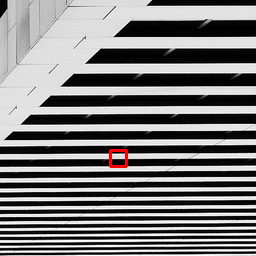

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch

window_size = 16  # Define windoes_size of D
img_lr, img_hr = prepare_images('/work/u1657859/ming0531/DRCT/FeatureVisualization/LAM_Demo/test_images/4.png')  # Change this image name
tensor_lr = PIL2Tensor(img_lr)[:3] ; tensor_hr = PIL2Tensor(img_hr)[:3]
cv2_lr = np.moveaxis(tensor_lr.numpy(), 0, 2) ; cv2_hr = np.moveaxis(tensor_hr.numpy(), 0, 2)
w = 110  # The x coordinate of your select patch, 125 as an example
h = 150  # The y coordinate of your select patch, 160 as an example
         # And check the red box
         # Is your selected patch this one? If not, adjust the `w` and `h`.


draw_img = pil_to_cv2(img_hr)
cv2.rectangle(draw_img, (w, h), (w + window_size, h + window_size), (0, 0, 255), 2)
position_pil = cv2_to_pil(draw_img)
position_pil

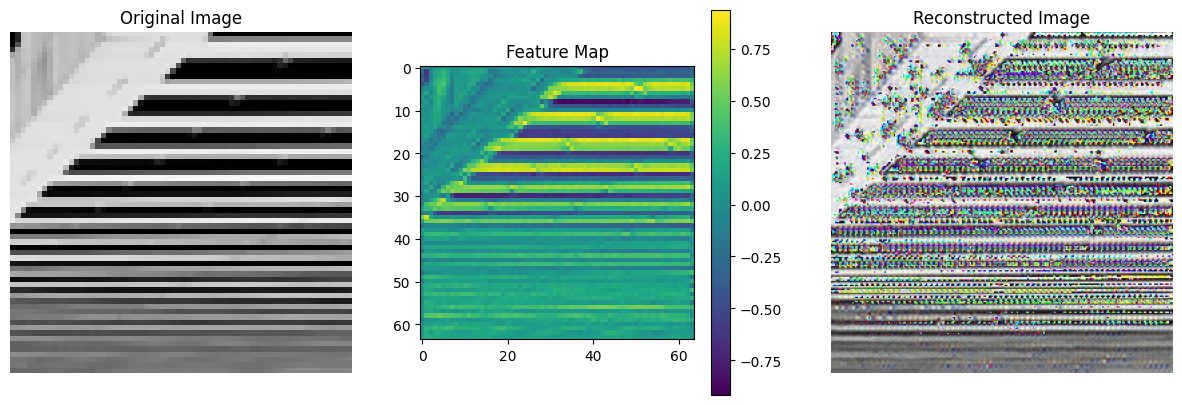

In [20]:
model.eval()  # 确保模型处于评估模式

with torch.no_grad():
    _, feature_maps = model(tensor_lr, return_feature_map=True)
with torch.no_grad():
    reconstructed, _ = model(tensor_lr, return_feature_map=False)
plt.figure(figsize=(15, 5))  # 调整整体图像大小


plt.subplot(1, 3, 1)  # 1行3列，这是第一个图像
plt.imshow(img_lr)
plt.title("Original Image")
plt.axis('off')  # 不显示坐标轴
# 可视化特徵图
# 选择一个特徵图进行展示，这里我们简单地选取第一个特徵图
feature_map_to_show = feature_maps[0, 0].cpu().numpy()  # 转换为 NumPy 数组并选择第一个特徵图
plt.subplot(1, 3, 2)  # 1行3列，这是第二个图像
# 因为特征图可能不是标准的RGB图像，所以使用灰度色彩映射来显示
plt.imshow(feature_map_to_show)
plt.title("Feature Map")
plt.colorbar()  # 显示色彩条

# 可视化重建图像
reconstructed_image = reconstructed[0].cpu().numpy()  # 转换为 NumPy 数组
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  # CHW -> HWC
reconstructed_image = (reconstructed_image * 255).astype(np.uint8)  # 缩放到 [0, 255] 范围并转换为 uint8
# 使用 matplotlib 显示图像
plt.subplot(1, 3, 3)  # 1行3列，这是第三个图像
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [21]:
feature_map_to_show
max_value = np.max(feature_map_to_show)
median_value = np.median(feature_map_to_show)
min_value = np.min(feature_map_to_show)

print("Max Value:", max_value)
print("Median Value:", median_value)
print("Min Value:", min_value)

Max Value: 0.9375563
Median Value: 0.11685763
Min Value: -0.9174164
